# Using GIXStapose to Generate Reproducible Figures

Imagine, you've just finished running a parameter sweep of 10 different temperatures, 10 different pressures, and 10 different compounds. You've used a GUI (perhaps the GIXStapose GUI!) for chemical structure visualization and painstakenly rotated and zoomed to create some really nice figures--it took you a day and a half, but now you're ready to add these figures to your publication. However, when you show the figures you made to your advisor, she asks for a view from a different angle and using a different color scheme...

GIXStapose is designed to save you time in these situations by generating and using metadata for orienting and visualizing chemical structures and their diffraction patterns. In this notebook, we demonstrate how to use the GIXStapose library outside of the GUI, including:
- reproducing the exact figure seen in the GUI 
- exploring real (messy) simulation data

![screenshot.png](../gixstapose/data/screenshot.png)

In [1]:
import PIL
import matplotlib.pyplot as plt
from fresnel import camera, pathtrace
import mbuild as mb

from gixstapose.draw_scene import get_scene, get_info
from gixstapose.diffractometer import Diffractometer

We'll use the `get_scene` function to load a gsd file into a [`fresnel.Scene`](https://fresnel.readthedocs.io/en/stable/examples/00-Basic-tutorials/04-Scene-properties.html).

`get_scene` by default will use the [cpk color map](https://en.wikipedia.org/wiki/CPK_coloring#Typical_assignments), but you can also use any [matplotlib colormap](https://matplotlib.org/tutorials/colors/colormaps.html). This is especially useful when working with coarse-grained or other non-atomistic systems.

In [2]:
scene, info = get_scene("../gixstapose/data/sc10.pdb")

Next we can set a `fresnel.camera` object with the same parameters as the one shown above in the GUI and connect that camera object to the scene.

You can easily get the camera parameters from the GUI by selecting "Print Camera" in the GIXStapose menu bar.

In [3]:
cam = camera.Orthographic(
    position = [1.412, 0.698, 0.720],
    look_at  = [0.000, 0.000, 0.000],
    up       = [-0.292, -0.333, 0.896],
    height   = 1.500
)
scene.camera = cam

The next cell will take a minute to run but shows how to easily recreate the same image as the GUI using fresnel's high quality pathtracer.

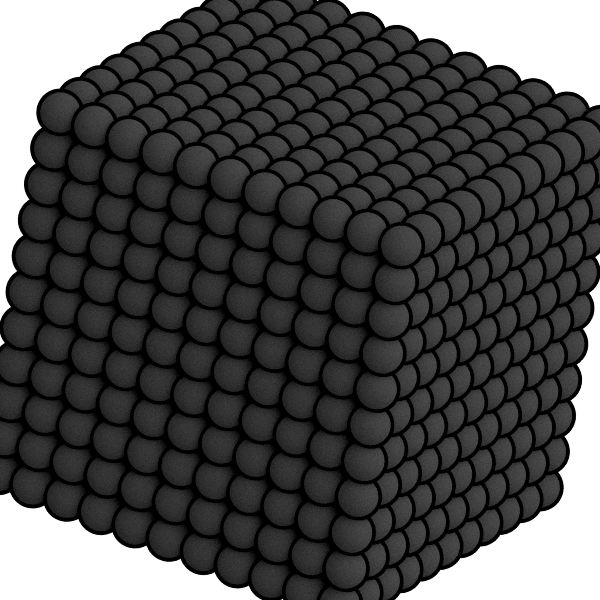

In [4]:
output = pathtrace(scene, light_samples=40, w=600, h=600)
output

Then we can save this output using python image library (PIL).

In [5]:
image = PIL.Image.fromarray(output[:], mode='RGBA')
image.save("structure.png", dpi=(300, 300))

In a similar fashion, we can use the `load_compound` function to load the compound particle positions and box into the `Diffractometer` class and then choose a diffraction angle based on the camera position using the `diffract_from_camera` function.

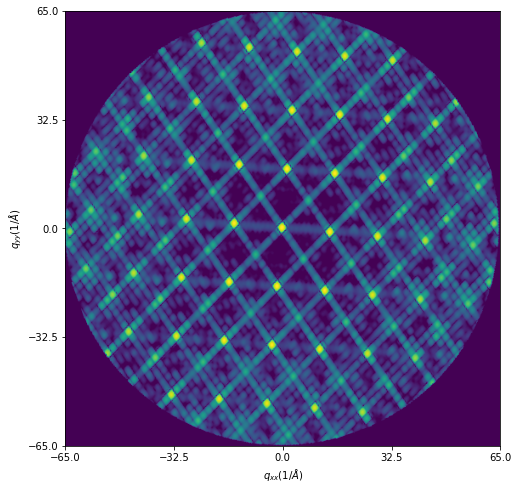

In [6]:
d = Diffractometer(length_scale=1.0)
d.load(info["positions"], info["box"])
d.diffract_from_camera(cam)
fig, ax = d.plot()

And the diffraction pattern can be easily saved using the `savefig` function.

In [7]:
fig.savefig("diffraction.png")

Finally let's look at a messy example using real simulation data. The original xml file was taken from [https://doi.org/10.18122/cme_lab/4/boisestate](https://doi.org/10.18122/cme_lab/4/boisestate).

The original file can be found in p3ht_data/1000_oligomers/crystallinities/crystalline.xml. The file was converted from an xml to a gsd using [cmeutils](https://github.com/cmelab/cmeutils) [xml_to_gsd](https://github.com/cmelab/cmeutils/blob/8e33350630891cde89c9ba82a9adc682407c320f/cmeutils/gsd_utils.py#L192) function, and reduced to contain only the backbone carbons (type CA) using [snap_delete_types](https://github.com/cmelab/cmeutils/blob/8e33350630891cde89c9ba82a9adc682407c320f/cmeutils/gsd_utils.py#L141) so it would load more quickly. 

This is from one of our united-atom simulations of organic photovoltaic polymers, specifically [P3HT](http://gisaxs.com/index.php/Material:P3HT). Even with these simplifications, it still contains 60,000 particles, so the following cells may be a little slow. The simulation snapshot is in [reduced units](https://hoomd-blue.readthedocs.io/en/latest/units.html) where 1 $\sigma$ = 3.905 Å; you will notice this scaling factor is used to help scale the particle radii in the scene and give the diffraction axis relevant units.

In [8]:
p3ht_file = "../gixstapose/data/crystalline_CAonly.gsd"

Next let's choose a camera position. I chose this camera position by using the GUI to find distinct diffraction peaks.

In [9]:
cam = camera.Orthographic(
   position = [2.892, 5.120, -0.830],
   look_at =  [-0.797, 0.604, 0.862],
   up =       [-0.733, 0.390, -0.557],
   height =   170
)

Next let's create a scene from this compound--I'm going to use a custom colormap to set the CA type to be gray. There's a lot of additional modifications that can be done to the fresnel scene--I highly recommend [their tutorials](https://fresnel.readthedocs.io/en/stable/examples/00-Basic-tutorials/00-Introduction.html). But for this example, lets just connect the camera and render it!

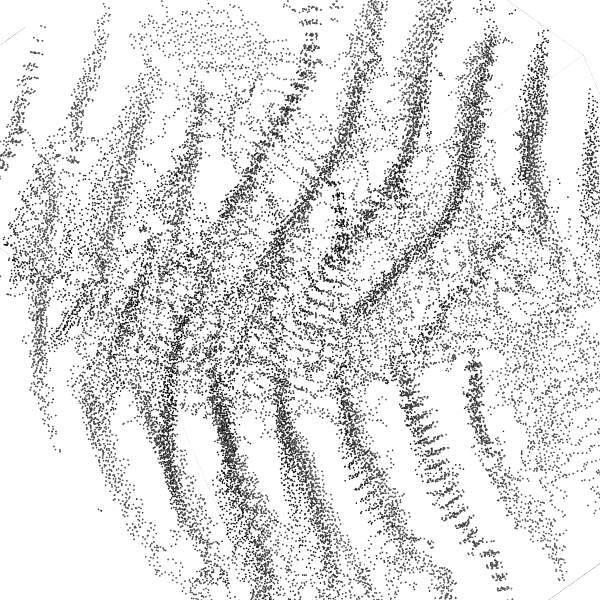

In [10]:
p3ht_scene, info = get_scene(p3ht_file, color={"CA": "gray"}, scale=3.905)
p3ht_scene.camera = cam
p3ht_output = pathtrace(p3ht_scene, light_samples=40, w=600, h=600)
p3ht_output

At this particular angle we'll draw your attention to parallel stripes of gray separated by black shadowy regions: These stripes are "lamellae" and are a periodic feature that should be measurable with the GIXStapose diffractometer. (Reminder! I used GIXStapose GUI to find an orientation with measurable lamellar peaks and saved its camera orientation so we *could* return to this precise orientation!)

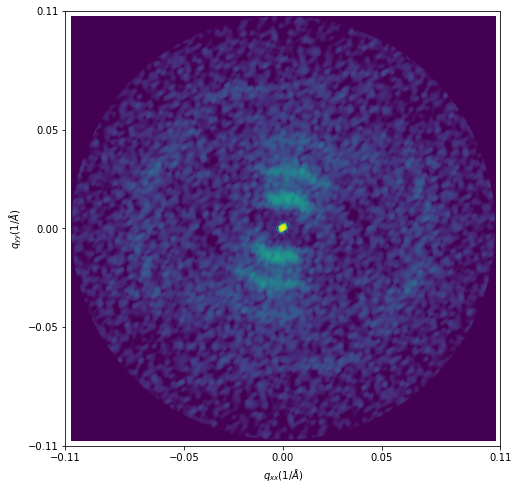

In [11]:
d = Diffractometer(length_scale=3.905)
d.load(info["positions"], info["box"])
dp = d.diffract_from_camera(cam)
fig, ax = d.plot()

Aw yeah, just look at that classic lamellar structure! The reflections of the (100) and (200) crystallographic planes are clearly visibile, with a hint of (300)! In this diffraction pattern, the wave vectors pointing to these yellow/green peak centers can be used to derive average lamellar spacings that would be a mess to deduce from the direct visualization. This example showcases how looking at chemical structures through the diffraction lens *first* can identify periodic features that may not be immediately visible to the eye. Once we know a periodic feature exists, we can pull up the chemical structure visualization and look for features at the expected length scales. We can also use this orientation as a reference point to generate a sequence of rotations that reveal other structures (e.g., for you P3HT experts, an orientation that more clearly reveals the spacing of the pi-pi stacking of the P3HT backbones).

In [1]:
#['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
#import matplotlib
#matplotlib.use('GTK3Cairo')
%matplotlib

Using matplotlib backend: <object object at 0x10ad12540>


In [2]:
import PIL
import matplotlib.pyplot as plt
from fresnel import camera, pathtrace
import mbuild as mb

from gixstapose.draw_scene import get_scene, get_info
from gixstapose.diffractometer import Diffractometer

p3ht_file = "../gixstapose/data/crystalline_CAonly.gsd"
info = get_info(p3ht_file)

cam = camera.Orthographic(
   position = [2.892, 5.120, -0.830],
   look_at =  [-0.797, 0.604, 0.862],
   up =       [-0.733, 0.390, -0.557],
   height =   170
)

d = Diffractometer(length_scale=3.905)
d.load(info["positions"], info["box"])
dp = d.diffract_from_camera(cam)

In [3]:
fig, ax = d.plot()

def onclick(event):
    circle = plt.Circle((event.xdata,event.ydata), 2.5, color='red', fill=False, lw=2)
    ax.add_patch(circle)
    distance = (event.xdata**2 + event.ydata**2)**(0.5)
    label = ax.annotate(
        rf"({distance:.3f} 1/$\AA$)", 
        xy=(event.xdata+2,event.ydata+2), 
        fontsize=20, 
        color="red"
    )
    plt.show()
    #fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
a = np.random.rand(10)
hist = np.histogram(a,bins=20,range=(0,10))

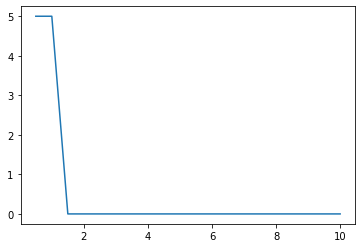

In [3]:
plt.plot(hist[1][1:], hist[0])
plt.show()

In [14]:
hist

(array([7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]))